In [1]:
import torch.nn as nn
import torch.nn.parallel

from torch.utils.data import DataLoader
from Models import MNIST_classifier

import os
import numpy as np
from mnist_prepare_subset_select_train_val_test import MNIST


import torch.optim as optim
from torch.optim import lr_scheduler
# import torchvision
import torchvision.transforms as transforms
from termcolor import cprint
# from knn_utils import calc_knn_graph, calc_topo_weights_with_components_idx
from noise import noisify_with_P, noisify_cifar10_asymmetric, noisify_cifar100_asymmetric, noisify_pairflip, noisify_modelnet40_asymmetric
import copy
from scipy.stats import mode
from matplotlib import pyplot as plt
import torch.nn.functional as F

from subset_select_ipot_non_uniform_git import subset_select_ipot as ss_ipot 

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = "cpu"


# Clean Data

In [2]:
def _init_fn(worker_id):
    np.random.seed(77 + worker_id)
    
models_path = "G:\\My Drive\\Research Codes\\Subset Selection Paper\\Neural Network Classifier\\models\\UCI-subset-select\\MNIST\\"

train_val_ratio = 0.8
trust_prop=1.0

batch_size_train = 512

num_classes = 10

noise_level = 0.8
random_seed = 42

transform_train = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
trainset = MNIST(root='./data', split='train',train_ratio=train_val_ratio, trust_prop=trust_prop,  download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True, num_workers=0, worker_init_fn=_init_fn)



# noise_y_train_labels0, noise_y_train_indices = trainset.get_noisy_labels_with_indices()
# noise_y_train, p, _ = noisify_with_P(noise_y_train_labels0, nb_classes=num_classes, noise=noise_level, random_state=random_seed)
# trainset.update_corrupted_label(noise_y_train, noise_y_train_indices)

valset = MNIST(root='./data', split='val', train_ratio=train_val_ratio, trust_prop=trust_prop, download=True, transform=transform_train)
valloader = torch.utils.data.DataLoader(valset, batch_size=512, shuffle=False, num_workers=0)

testset = MNIST(root='./data', split='test',download=True, transform=transform_train)
testloader = torch.utils.data.DataLoader(testset, batch_size=512, shuffle=False, num_workers=0)

max_epochs = 100
unique_labels = [int(i) for i in list(np.linspace(0, 10, 10, endpoint=False))]
torch.manual_seed(0)

net = MNIST_classifier().to(device)
criterion = nn.CrossEntropyLoss(reduction='mean')
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)
optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-4)


# net = Models.MNIST_classifier().to(device)
# criterion = nn.CrossEntropyLoss(reduction='mean')
# # optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)
train_acc = []
val_acc = []
best_accuracy = 0

for epoch in range(max_epochs):  # loop over the dataset multiple times

    running_loss = []
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        # _, images, labels, _, _ = data
        images, labels, _, _, _ = data
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, _ = net(images.double().to(device))
        loss = criterion(outputs, labels.long().to(device))
        loss.backward()
        optimizer.step()

        running_loss.append(loss.item())
        # avg_loss.append(torch.tensor(running_loss).mean())
    print("epoch={0:d},  avg_loss = {1:0.4f}".format(
        epoch, torch.tensor(running_loss).mean()))

    if True:
        classes = tuple([str(i) for i in unique_labels])
        correct_pred = {classname: 0 for classname in classes}
        total_pred = {classname: 0 for classname in classes}
        total = 0
        correct = 0

        net.eval()
        with torch.no_grad():
            for data in valloader:
                images, labels,_,_,_ = data
                outputs, _ = net(images.double().to(device))
                _, predictions = torch.max(outputs, dim=1)
                total += labels.size(0)
                correct += (predictions.cpu() == labels).sum().item()
            print(f'val set accuraccy: {100 * correct / total} %')
            val_acc.append(100 * correct / total)
            
        if val_acc[-1] > best_accuracy:
            best_accuracy = val_acc[-1]
            net_path = models_path + "MNIST_clean"+".pth"
            torch.save({
                'epoch': epoch,
                'model_state_dict': net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val-accuracy': val_acc,
                'train-accuracy': train_acc}, net_path)
            
        
        classes = tuple([str(i) for i in unique_labels])
        correct_pred = {classname: 0 for classname in classes}
        total_pred = {classname: 0 for classname in classes}
        total = 0
        correct = 0
        net.eval()
        with torch.no_grad():
            for data in trainloader:
                images, labels, _, _, _ = data
                outputs, _ = net(images.double().to(device))
                _, predictions = torch.max(outputs, dim=1)
                total += labels.size(0)
                correct += (predictions.cpu() == labels).sum().item()
        print(f'train set accuracy: {100 * correct / total} %')
        train_acc.append(100 * correct / total)

        


print('Finished Training')
# saving training accuracy list along with model with best accuracy
net_path = models_path + "MNIST_clean"+".pth"
best_net_dict = torch.load(net_path)
best_net_dict['val-accuracy'] = val_acc
best_net_dict['train-accuracy'] = train_acc
torch.save(best_net_dict, net_path)


epoch=0,  avg_loss = 0.8430
val set accuraccy: 90.0 %
train set accuracy: 89.36666666666666 %
epoch=1,  avg_loss = 0.3013
val set accuraccy: 93.1 %
train set accuracy: 92.71875 %
epoch=2,  avg_loss = 0.2200
val set accuraccy: 94.54166666666667 %
train set accuracy: 94.65833333333333 %
epoch=3,  avg_loss = 0.1716
val set accuraccy: 95.55833333333334 %
train set accuracy: 95.69375 %
epoch=4,  avg_loss = 0.1431
val set accuraccy: 96.31666666666666 %
train set accuracy: 96.33125 %
epoch=5,  avg_loss = 0.1196
val set accuraccy: 96.50833333333334 %
train set accuracy: 96.78541666666666 %
epoch=6,  avg_loss = 0.1065
val set accuraccy: 96.41666666666667 %
train set accuracy: 96.93958333333333 %
epoch=7,  avg_loss = 0.0927
val set accuraccy: 96.56666666666666 %
train set accuracy: 97.0625 %
epoch=8,  avg_loss = 0.0822
val set accuraccy: 97.1 %
train set accuracy: 97.59375 %
epoch=9,  avg_loss = 0.0765
val set accuraccy: 96.55 %
train set accuracy: 97.53541666666666 %
epoch=10,  avg_loss = 0.071

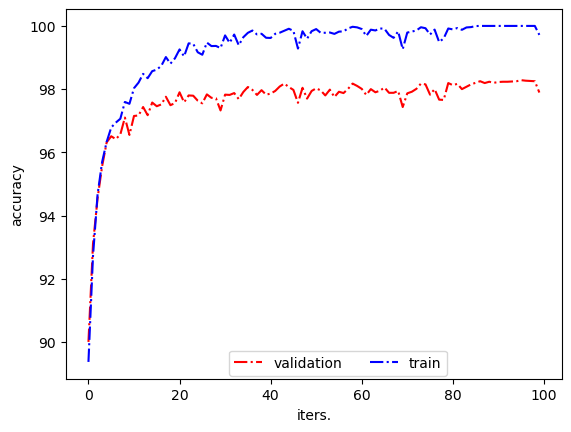

In [4]:
from matplotlib import pyplot as plt
net_path = models_path + "MNIST_clean"+".pth"
best_net_dict = torch.load(net_path)


iters = list(range(0, 100))
fig, axs = plt.subplots()
axs.plot(iters, best_net_dict['val-accuracy'], "-.", color="r", label="validation")
axs.plot(iters, best_net_dict['train-accuracy'], "-.", color="b", label="train")
axs.set_xlabel("iters.")
axs.set_ylabel("accuracy")
fig.legend(ncol=3, loc=(0.4, 0.13))
